In [1]:
%matplotlib inline
import os

from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt

In [14]:
root_path = '../data/fashionpedia'
data_type = 'train2020'
ann_file_path = '{}/annotations/instances_attributes_{}.json'.format(root_path, data_type)
img_path = '{}/train'.format(root_path)

def get_img_path(file_name):
    return os.path.join(img_path, '{}'.format(file_name))

coco = COCO(ann_file_path)

loading annotations into memory...
Done (t=4.24s)
creating index...
index created!


In [5]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
shirt, blouse top, t-shirt, sweatshirt sweater cardigan jacket vest pants shorts skirt coat dress jumpsuit cape glasses hat headband, head covering, hair accessory tie glove watch belt leg warmer tights, stockings sock shoe bag, wallet scarf umbrella hood collar lapel epaulette sleeve pocket neckline buckle zipper applique bead bow flower fringe ribbon rivet ruffle sequin tassel

COCO supercategories: 
others waist lowerbody neck wholebody head closures garment parts legs and feet decorations arms and hands upperbody


In [8]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=nms)
print(f'{catIds=}')
imgIds = coco.getImgIds(catIds=catIds)
print(f'{imgIds[:10]=}')

catIds=[]
imgIds[:10]=[16145, 12446, 17264, 10359, 17672, 17107, 9459, 11278, 9446, 13028]


img={'id': 16145, 'width': 1024, 'height': 1024, 'file_name': '6ce91b2c047f7f441edd5dc17326ae17.jpg', 'license': 2, 'time_captured': 'March-August, 2018', 'original_url': 'https://farm4.staticflickr.com/3723/32517258013_5dbb981cfb_o.jpg', 'isstatic': 1, 'kaggle_id': '6ce91b2c047f7f441edd5dc17326ae17'}


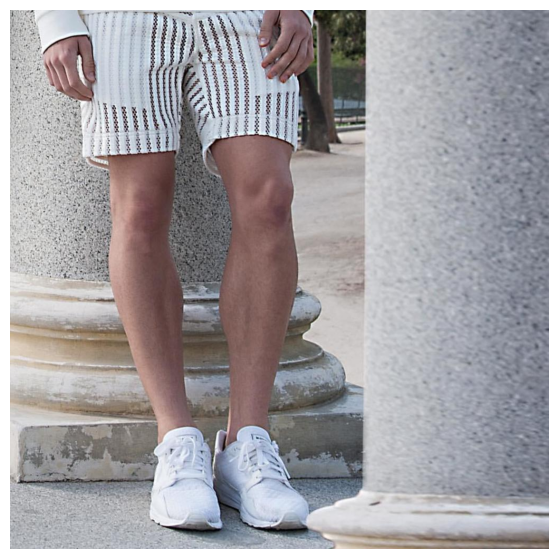

In [19]:
plt.figure(figsize=(7, 7))
# plot image: 322
imgId = 16145
img = coco.loadImgs(imgId)[0]
print(f'{img=}')
I = plt.imread(get_img_path(img['file_name']))
plt.axis('off')
plt.imshow(I)
plt.show()

In [25]:
# Make dataset for pytorch, based on coco dataset
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CocoDataset(Dataset):
    def __init__(self, data_path, data_type, transform=None):
        self.data_path = data_path
        self.data_type = data_type
        self.transform = transform
        self.coco = COCO(ann_file_path)

        # display COCO categories and supercategories
        cats = self.coco.loadCats(self.coco.getCatIds())
        nms=[cat['name'] for cat in cats]
        nms = set([cat['supercategory'] for cat in cats])
        # get all images containing given categories, select one at random
        catIds = self.coco.getCatIds(catNms=nms)
        imgIds = self.coco.getImgIds(catIds=catIds)


        self.catIds = catIds
        self.imgIds = imgIds
        self.cat2idx = {cat: idx for idx, cat in enumerate(self.catIds)}

    def __len__(self):
        return len(self.imgIds)

    def __getitem__(self, idx):
        imgId = self.imgIds[idx]
        img = self.coco.loadImgs(imgId)[0]
        annIds = self.coco.getAnnIds(imgIds=img['id'], catIds=self.catIds, iscrowd=None)
        anns = self.coco.loadAnns(annIds)

        img_path = get_img_path(img['file_name'])
        I = plt.imread(img_path)
        if self.transform:
            I = self.transform(I)

        return I, anns

class CocoDataloader(DataLoader):
    def __init__(self, dataset, batch_size=1, shuffle=False, num_workers=0, transform=None):
        self.dataset = dataset
        super().__init__(self.dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]


In [26]:
# Test dataloader
transform = transforms.Compose([
])
dataset = CocoDataset(root_path, data_type, transform=transform)
dataloader = CocoDataloader(dataset, batch_size=1, shuffle=True, num_workers=0)
print(f'{len(dataloader)=}')


loading annotations into memory...
Done (t=5.59s)
creating index...
index created!
len(dataloader)=45623


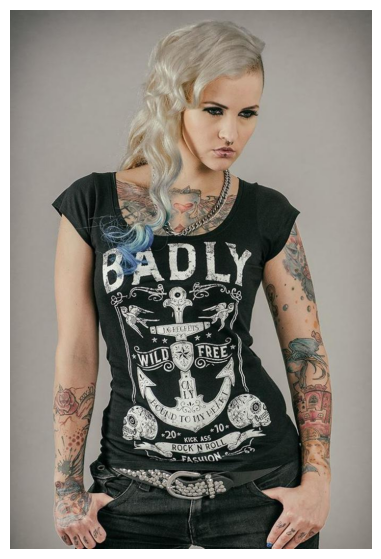

In [43]:
plt.figure(figsize=(7, 7))
I, anns = next(iter(dataloader))
plt.axis('off')
plt.imshow(I[0])
plt.show()